In [1]:
from sklearn.model_selection import train_test_split
import random
import datetime
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from google.cloud import datastore
import os
import matplotlib as plt
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = \
    "C:\\Users\\roman\\Downloads\\secrets.json"


client = datastore.Client()
query = client.query(kind="pricedata")
x = []
y = []
for i in query.fetch():
    x.append([i['smolprice'], i['chonkprice'], i['absprice'],i["balance"],i['coins']])


In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
data = pd.DataFrame(x,columns=['smolprice','chonkprice','absprice','balance','coins'])
data

,smolprice,chonkprice,absprice,balance,coins
0,5,205,155,1549,40
1,284,548,525,1549,1992
2,163,210,415,1549,910
3,252,266,385,1549,1342
4,43,265,212,1549,470
5,5,355,355,1549,150
6,252,266,385,1549,545
7,455,55,5,1549,725
8,205,55,55,56,230
9,5,355,355,1549,280


In [5]:
data.describe()


,smolprice,chonkprice,absprice,balance,coins
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,167.793103,237.793103,357.172414,1433.517241,891.758621
std,173.726875,195.267103,207.400763,389.342084,653.592690
min,5.000000,5.000000,5.000000,38.000000,0.000000
25%,5.000000,55.000000,212.000000,1549.000000,360.000000
50%,93.000000,210.000000,385.000000,1549.000000,817.000000
75%,252.000000,355.000000,542.000000,1549.000000,1268.000000
max,555.000000,566.000000,555.000000,1549.000000,2104.000000


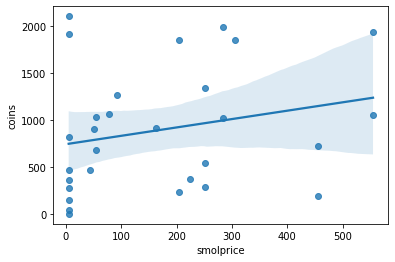

In [10]:
sns.regplot(x=data['smolprice'], y=data['coins'])

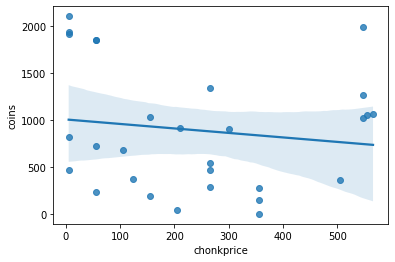

In [11]:
sns.regplot(x=data['chonkprice'], y=data['coins'])

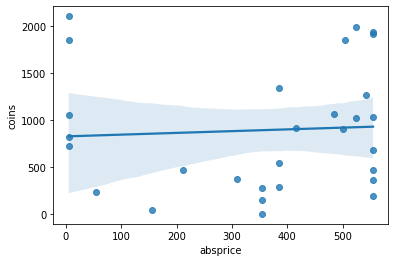

In [12]:
sns.regplot(x=data['absprice'], y=data['coins'])

In [37]:
rf_model = RandomForestRegressor(random_state=1)
y = data.coins
X = data[['smolprice','chonkprice','absprice']]
# fit your model
rf_model.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [9]:
print(X_test)
print(Y_test)

[[-0.84183725 -0.10115591 -0.10115591  2.42562558]
 [-0.84183725 -0.41859077 -0.52440239  2.42562558]]
[[-0.15722824]
 [-0.93048191]]


In [10]:
model.fit(X_train, Y_train,
          validation_data=(X_test,Y_test), 
          batch_size=20, 
          epochs=25,
          verbose=1)

Epoch 1/25
1/1 [==============================] - 0s 219ms/step - loss: 2.2670 - mae: 1.3411 - val_loss: 2.4195 - val_mae: 1.5124
Epoch 2/25
1/1 [==============================] - 0s 32ms/step - loss: 2.1226 - mae: 1.2920 - val_loss: 2.1759 - val_mae: 1.4297
Epoch 3/25
1/1 [==============================] - 0s 34ms/step - loss: 1.9926 - mae: 1.2451 - val_loss: 1.9569 - val_mae: 1.3510
Epoch 4/25
1/1 [==============================] - 0s 29ms/step - loss: 1.8759 - mae: 1.2004 - val_loss: 1.7610 - val_mae: 1.2764
Epoch 5/25
1/1 [==============================] - 0s 29ms/step - loss: 1.7718 - mae: 1.1581 - val_loss: 1.5861 - val_mae: 1.2059
Epoch 6/25
1/1 [==============================] - 0s 29ms/step - loss: 1.6792 - mae: 1.1180 - val_loss: 1.4306 - val_mae: 1.1396
Epoch 7/25
1/1 [==============================] - 0s 39ms/step - loss: 1.5971 - mae: 1.0802 - val_loss: 1.2928 - val_mae: 1.0774
Epoch 8/25
1/1 [==============================] - 0s 34ms/step - loss: 1.5246 - mae: 1.0447 - va

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
%tensorboard --logdir logs/fit


In [13]:
key = client.key("thoughtcoins", 5713227891605504)
entity = client.get(key=key)
balance = entity["balance"]

In [14]:
balance

659

In [15]:
data = []
maxval = 0
stepsize = 50
maxvaldat = [[5, 5, 5]]
for smol in range(5, 600, stepsize):
    for chonk in range(5, 600, stepsize):
        for abso in range(5, 600, stepsize):
            x = np.array([[smol, chonk, abso,balance]])
            dat = Normalize(x, xmean_data, xstd_data)[0]
            pred = model.predict(dat)
            data.append([smol,chonk,abso,pred[0][0] *ystd_data + ymean_data])
            if(pred > maxval):
                maxval = pred
                maxvaldat = [[smol, chonk, abso]]


In [16]:
def keyfunc(e):
    return e[3]

In [17]:
data.sort(reverse=True,key=keyfunc)

In [18]:
data

[[5, 5, 555, 293.4400374723081],
 [5, 55, 555, 292.3807494369875],
 [5, 5, 505, 291.68644591110257],
 [55, 5, 555, 291.3537391006297],
 [5, 555, 555, 291.33716319103195],
 [5, 105, 555, 291.32146140166685],
 [5, 55, 505, 290.53788430016505],
 [5, 505, 555, 290.4953391571991],
 [55, 55, 555, 290.2944487528217],
 [5, 155, 555, 290.2621710538589],
 [5, 5, 455, 290.0092543082244],
 [5, 455, 555, 289.6535104983915],
 [55, 5, 505, 289.57831765848067],
 [5, 105, 505, 289.3893226892275],
 [5, 555, 505, 289.35710511493676],
 [105, 5, 555, 289.26743610397654],
 [55, 105, 555, 289.2351584050137],
 [5, 205, 555, 289.20288070605085],
 [55, 555, 555, 289.18531967682577],
 [5, 55, 455, 288.8606973222617],
 [5, 405, 555, 288.81169108953344],
 [5, 505, 505, 288.5152764561292],
 [55, 55, 505, 288.42975604754315],
 [55, 505, 555, 288.34349564299293],
 [5, 5, 405, 288.3320719552958],
 [5, 155, 505, 288.27457426887855],
 [105, 55, 555, 288.2081503811433],
 [55, 155, 555, 288.17586805720566],
 [5, 255, 555,

In [20]:
newprice = random.choice(data[:20])
newprice

[55, 105, 555, 289.2351584050137]

In [38]:
client = datastore.Client()
key = client.key('prices', 5631671361601536)
entity = datastore.Entity(key=key)
entity.update({
    "smolprice": newprice[0],
    "chonkprice": newprice[1],
   "absprice": newprice[2]    })
client.put(entity)

## import matplotlib.pyplot as plt

In [111]:
(8-2)/3

2.0

In [112]:
2.0*3+2

8.0